# Workflow

In [1]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms 

## Downloading the Data

To download the data, we'll use the Data folder which contains ways to download data. Here we'll start off by using the EEG_BCI motor imagery dataset.

If we want to download the entire dataset, we can do the following:

In [8]:
# from Data import download_EEGBCI

# if input("Are you sure you want to download the entire dataset? (Y/N)") in "Yy":
#     total_subjects = list(range(1, 110))
#     runs = list(range(1, 15))
#     download_EEGBCI(total_subjects, runs, './EEGData', False)
#     print("Downloaded everything!")

# else:
#     print("Download cancelled.")


# # Only downloading a subset of the dataset
# subjects = [x for x in range(1,10)]
# runs = [1, 2]
# download_EEGBCI(subjects, runs, './EEGData', False)

## Loading the Data

This step is critical for actually getting the data into the ML algorithms. To do this, we'll have to rely on MNE's import functions to load the data into a format that we can use.

In [2]:
main_folder = './EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0'

subdirectories = [f.path for f in os.scandir(main_folder) if f.is_dir()]

opened_files = []
closed_files = []

for subdirectory in subdirectories:
    files = os.listdir(subdirectory)
    
    if len(files) > 0:
        for file in files:
            
            if file[-6:] == '01.edf':
                # This is data for eyes opened
                eyes_opened = os.path.join(subdirectory, file)
                print(eyes_opened)
                opened_files.append(eyes_opened)

            if file[-6:] == '02.edf':
                # This is data for eyes closed
                eyes_closed = os.path.join(subdirectory, file)
                print(eyes_closed)
                closed_files.append(eyes_closed)
    else:
        print(f"No files found in {subdirectory}")

./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S001\S001R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S001\S001R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S002\S002R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S002\S002R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S003\S003R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S003\S003R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S004\S004R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S004\S004R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S005\S005R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S005\S005R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S006\S006R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S006\S006R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S007\S007R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S007\S007R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S008\S008R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb

### More Detailed Ways of Working With MNE

In [10]:
data_loc = "./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/"
raw = mne.io.read_raw_edf('./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf', preload=True)
annotations = raw.annotations
annotations 

Extracting EDF parameters from C:\Users\joshua.park\Desktop\eeg-wgan\scripts\EEGData\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


<Annotations | 1 segment: T0 (1)>

Event: T0, Count: 1
Extracting EDF parameters from C:\Users\joshua.park\Desktop\eeg-wgan\scripts\EEGData\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG data shape: (64, 20000)
Extracting EDF parameters from C:\Users\joshua.park\Desktop\eeg-wgan\scripts\EEGData\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\joshua.park\Desktop\eeg-wgan\scripts\EEGData\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\joshua.park\Desktop\eeg-wgan\scripts\EEGData\MNE-eegbci-data\files\ee

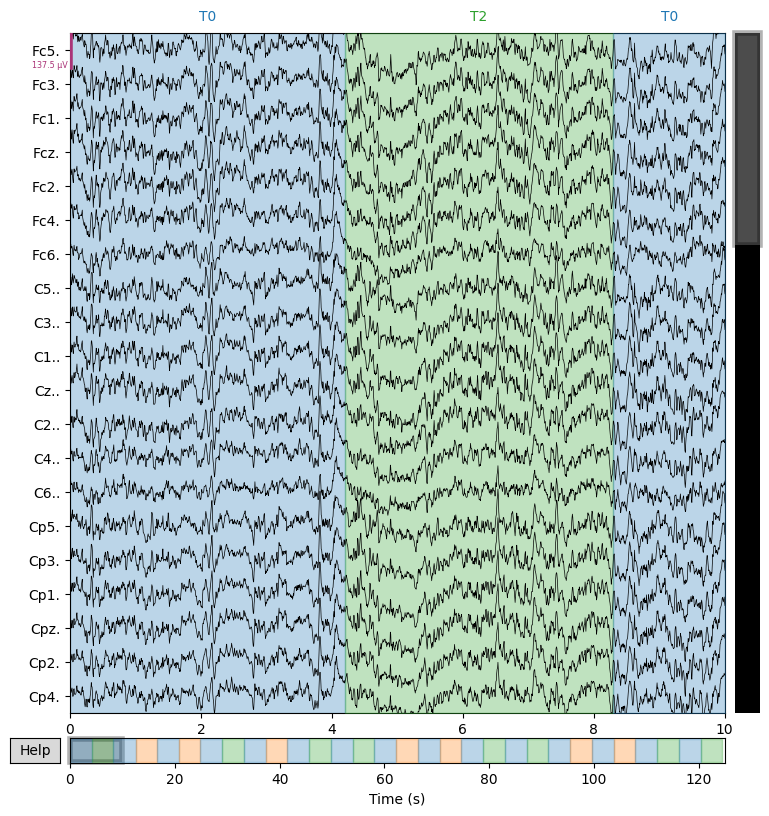

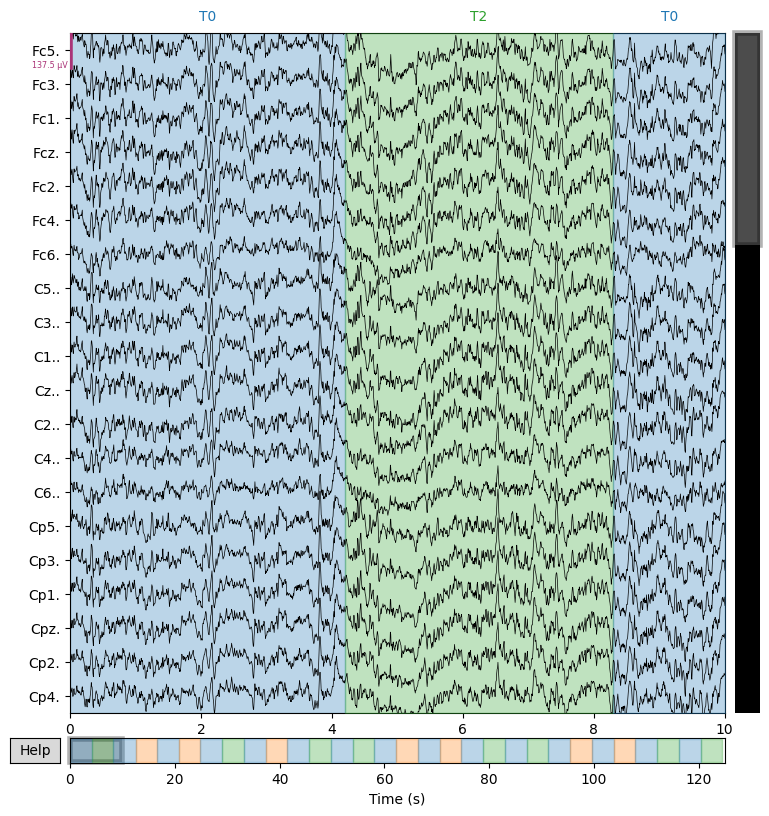

In [11]:
event_descriptions, event_counts = np.unique(annotations.description, return_counts=True)

# Print event descriptions and their counts
for desc, count in zip(event_descriptions, event_counts):
    print(f"Event: {desc}, Count: {count}")

# Select specific event type (replace 'event_type' with your desired event description)
event_type = 'event_type'
events = annotations[annotations.description == event_type]

# Print out event onset times and durations
for idx, event in enumerate(events):
    print(f"Event {idx + 1}: Onset: {event['onset']:.2f}, Duration: {event['duration']:.2f}")

# Replace 'your_file.edf' with the actual path to your EDF file
raw =  mne.io.read_raw_edf('./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf', preload=True)

# Get EEG data for all channels
eeg_data = raw.get_data()

# Print the shape of the EEG data array
print("EEG data shape:", eeg_data.shape)

# List of EDF file paths
edf_files = ['./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf', 
'./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf',
'./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf']

# List comprehension to read all EDF files
raw_list = [mne.io.read_raw_edf(edf_file, preload=True) for edf_file in edf_files]

# Extract EEG data for all channels from each raw object
eeg_data_list = [raw.get_data() for raw in raw_list]

# Print the shape of the EEG data arrays for each file
for idx, eeg_data in enumerate(eeg_data_list):
    print(f"EEG data shape for file {edf_files[idx]}:", eeg_data.shape)

raw_list[0].plot(scalings='auto', title='EEG Channels')

## Visualizing the Data

In [12]:
def basic_plot(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    eeg_data = data.get_data()
    time = data.times
    plt.figure(figsize=(10, 6))
    for ch_idx in range(eeg_data.shape[0]):
        plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('EEG Data for All Channels')
    return plt.show()

def double_plot(file1, file2):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Eyes Opened vs Eyes Closed')

    data1 = mne.io.read_raw_edf(file1, preload=True, verbose=False)
    data1.filter(1.0, 30.0, fir_design="firwin", skip_by_annotation="edge", verbose=False)
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800, verbose=False)
    ica.fit(data1, verbose=False)
    ica.exclude = [1, 2]
    data1 = ica.apply(data1, verbose=False)

    
    data2 = mne.io.read_raw_edf(file2, preload=True, verbose=False)
    data2.filter(1.0, 30.0, fir_design="firwin", skip_by_annotation="edge", verbose=False)
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800, verbose=False)
    ica.fit(data2, verbose=False)
    ica.exclude = [1, 2]
    data2 = ica.apply(data2, verbose=False)
    

    good_channels1 = data1.info['ch_names']
    good_channels2 = data2.info['ch_names']

    eeg_data1 = data1.get_data(picks=good_channels1)
    eeg_data2 = data2.get_data(picks=good_channels2)

    time = data1.times

    ax1.plot(time, eeg_data1[0])
    ax1.set_title('Eyes Opened')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    for ch_idx in range(eeg_data1.shape[0]):
        ax1.plot(time, eeg_data1[ch_idx], label=f'Channel {ch_idx + 1}')
    ax1.set_xlim(0, 5)
    ax1.set_ylim(-0.0002, 0.0002)

    ax2.plot(time, eeg_data2[0])
    ax2.set_title('Eyes Closed')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    for ch_idx in range(eeg_data2.shape[0]):
        ax2.plot(time, eeg_data2[ch_idx], label=f'Channel {ch_idx + 1}')
    ax2.set_xlim(0, 5)
    ax2.set_ylim(-0.0002, 0.0002)
    return plt.show()

Effective window size : 12.800 (s)


C:\Users\joshua.park\AppData\Local\Temp\ipykernel_9548\2635844998.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
C:\Users\joshua.park\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


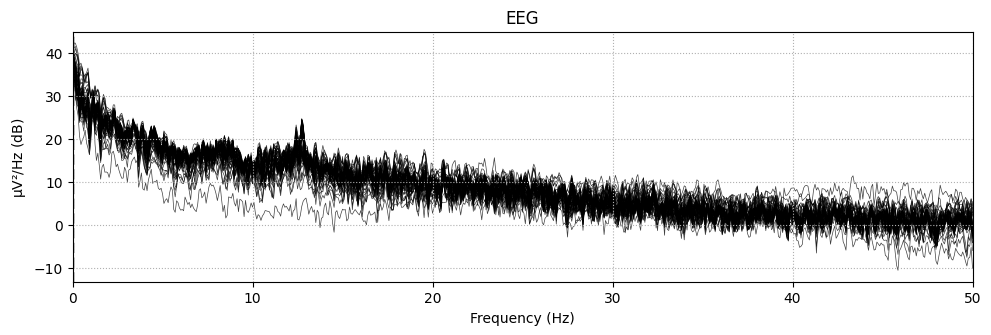

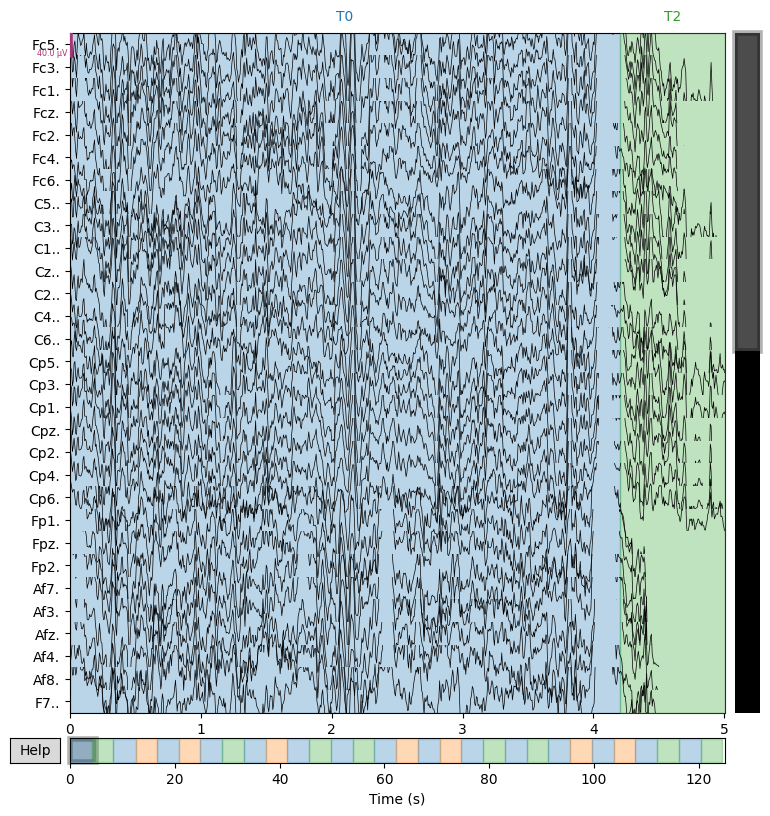

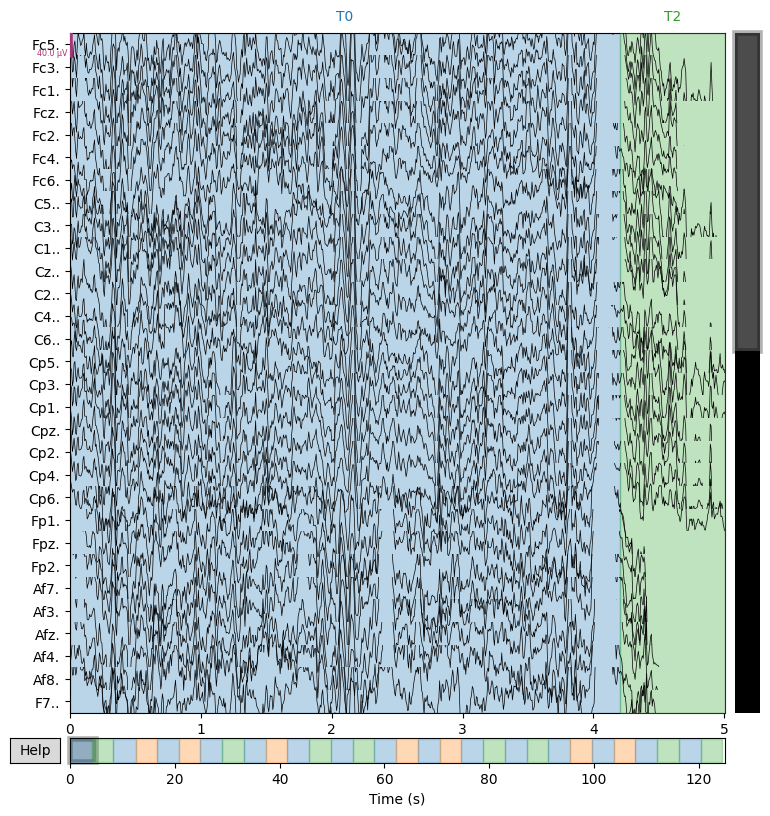

In [13]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
raw.plot(duration=5, n_channels=30)

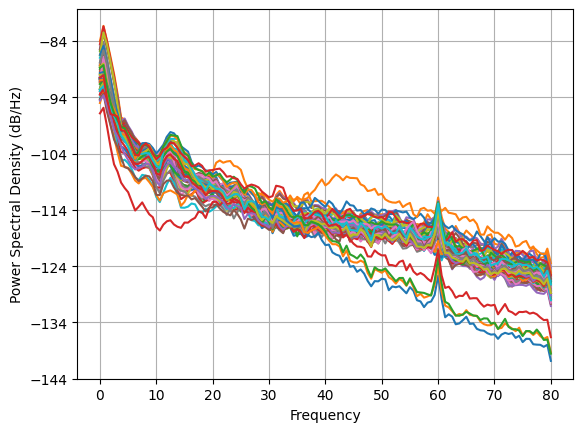

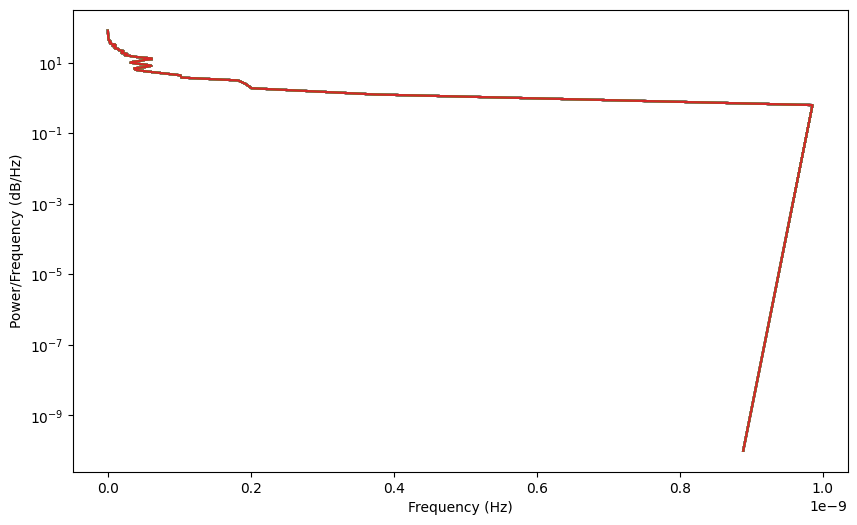

In [14]:
# Load the raw EEG data
edf_file = './EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf'
raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=nperseg, noverlap=noverlap)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd


# Get the EEG data using .get_data()
eeg_data = raw.get_data()
#eeg_data = large_closed_data[0]

# Set the sampling frequency
fs = raw.info['sfreq']

# Compute PSD using the custom function
freqs, psd = compute_psd(eeg_data, fs)

# Plot the PSD
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(eeg_data.shape[0]):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

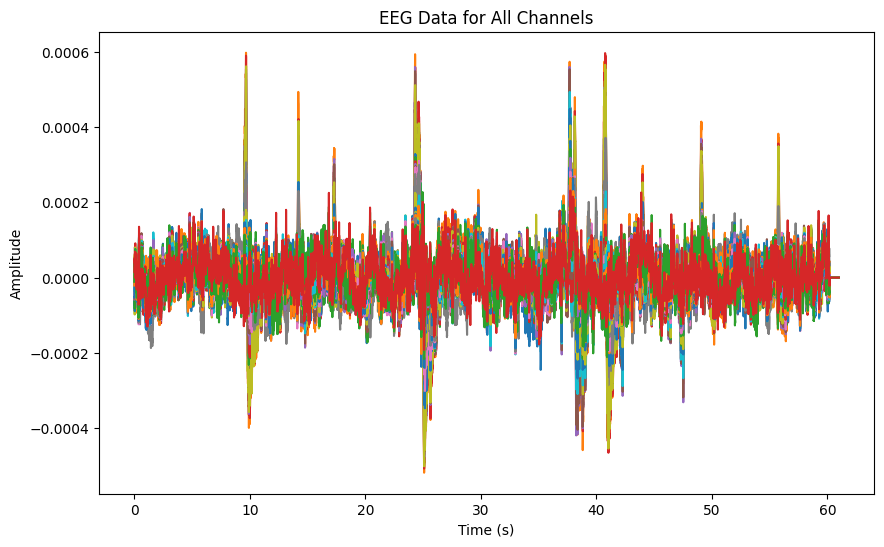

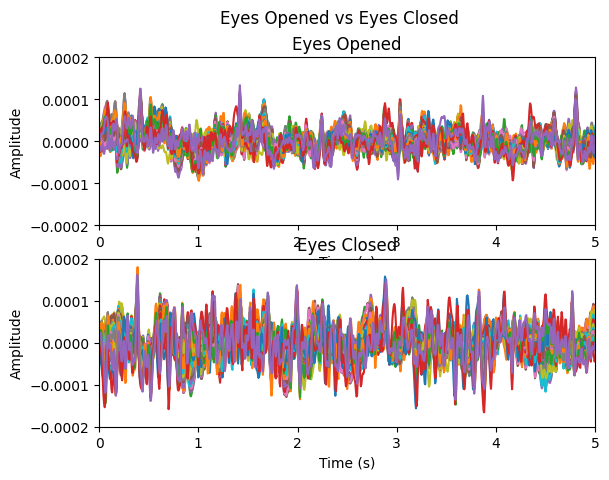

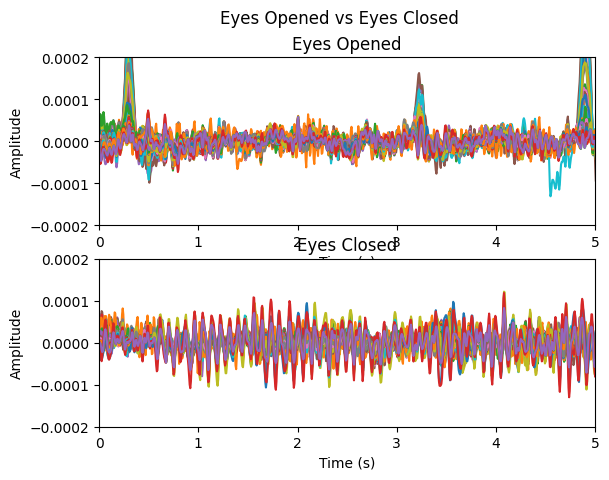

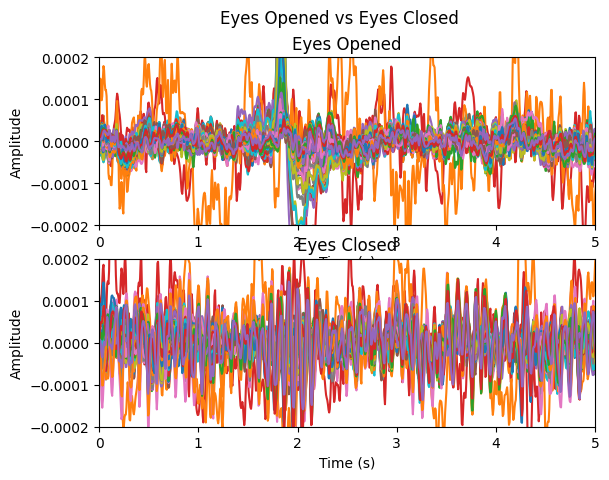

In [15]:
basic_plot(opened_files[0])

for i in range(3):
    double_plot(opened_files[i], closed_files[i])

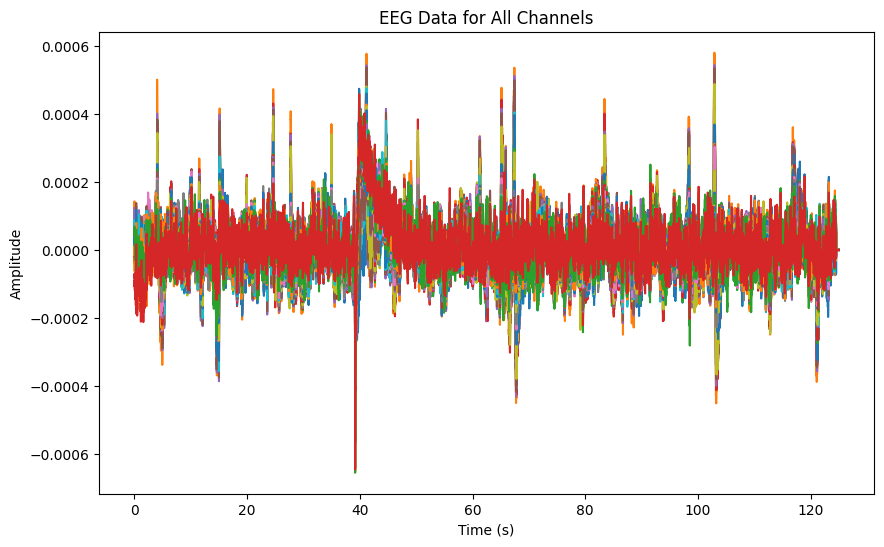

In [16]:
eeg_data = raw_list[0].get_data()
time = raw_list[0].times

# Plot EEG data for all channels using Matplotlib
plt.figure(figsize=(10, 6))
for ch_idx in range(eeg_data.shape[0]):
    plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.show()

### Machine Learning with MNE

Do you want to set the path:
    C:\Users\joshua.park\Desktop\eeg-wgan\scripts\EEGData
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\joshua.park\AppData\Local\Temp\ipykernel_9548\488142199.py:60: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot(n_channels=1, n_epochs=1, scalings='auto')


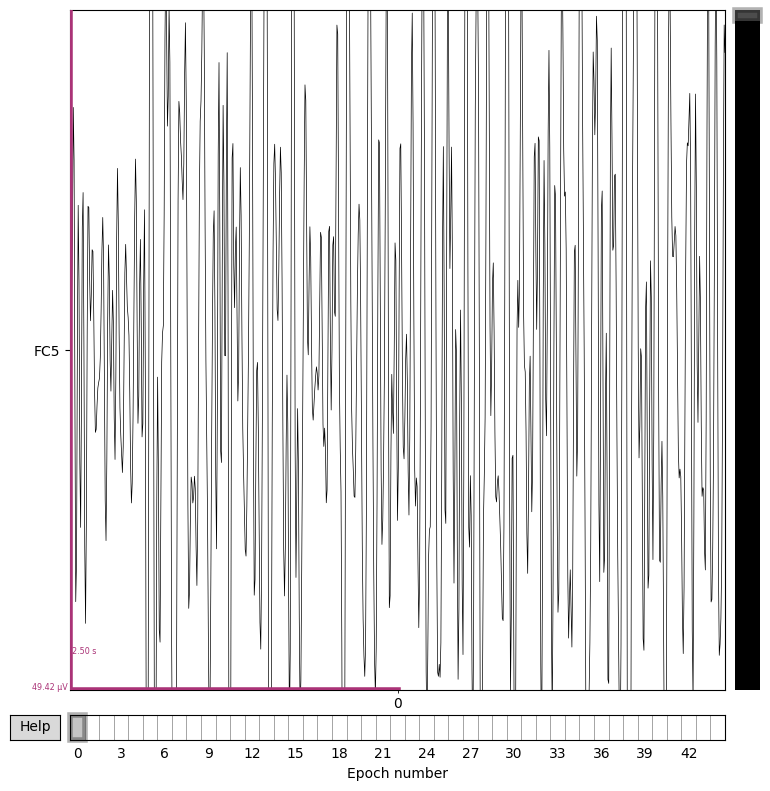

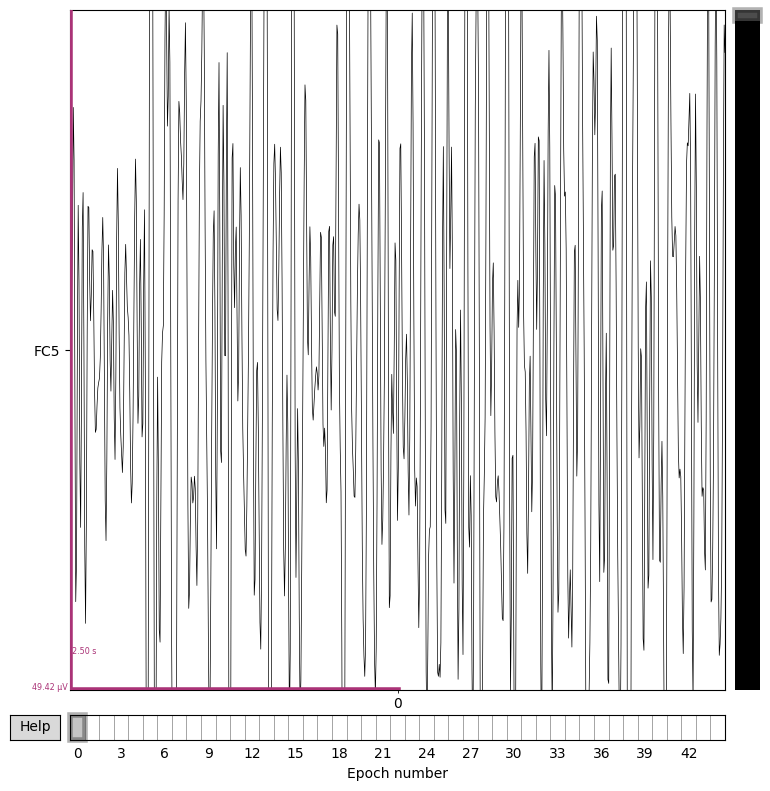

In [17]:
# DEfine the time window for epochs around the events
t_min, t_max = -1., 4.

# Dictionary that maps event names to their corresponding event codes.
# Event codes are numeric identifiers that are used to label different type of events or triggers in EEG/MEG data.
event_id = {'hands': 2, 'feet': 3}

# This is the subject we choose to study. Can be in the range of 1-109 (inclusive)
subject = 1

# This is the run we choose to study. Can be in the range of 1-14 (inclusive)
runs = [6, 10, 14]  # motor imagery: hands vs feet

# Loads in the subject and runs you're interested in
raw_fnames = mne.datasets.eegbci.load_data(subject, runs, './EEGData', verbose=False)

# Loads in the data file then reads and concatenates the data into the `raw` object
raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])

# Set channel names in the EEG data
mne.datasets.eegbci.standardize(raw)

# This creates an info object that represents the 10/05 electrode positions 
montage = mne.channels.make_standard_montage("standard_1005")

# Attaches the montage to the raw data
raw.set_montage(montage)

# This applies a bandpass filter (finite impulse response) to the data and avoids filtering data near the edge
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

# This line extracts information from annotations present in the raw data.
# Annotations are labels attached to specific points in the data and usually represent events or important time segments.
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# This line selects specific channel types from the raw data
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

epochs = mne.Epochs(
    raw, # Datase
    events, # Events
    event_id, # Event ID
    t_min, # Start time
    t_max, # End time
    proj=True, # Apply SSP projection vectors
    picks=picks, # Channels to include
    baseline=None, # Baseline interval
    preload=True, # Load data into memory
)

# This creates a new epochs object by copying the original epochs object and cropping the time interval from 1 to 2 seconds.
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)

# This creates a numpy array that contains the labels for each epoch. 
# The labels are stored in the last column of the events array. 
# The labels are stored as integers, but we want them to be 0 and 1. 
# We can subtract 2 from the labels to get the desired values.
labels = epochs.events[:, -1] - 2

epochs.plot(n_channels=1, n_epochs=1, scalings='auto')

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

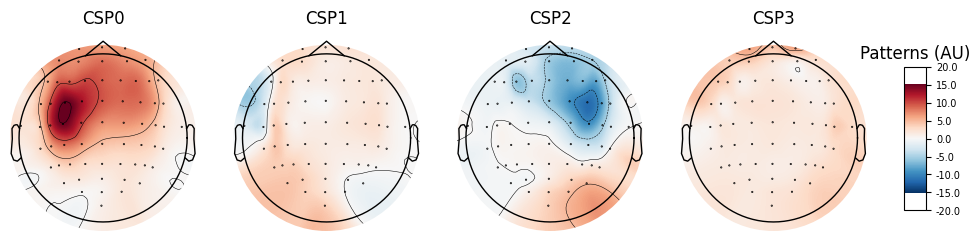

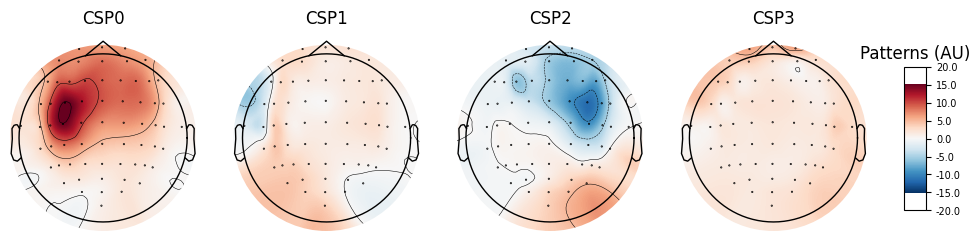

In [18]:
# Define a monte-carlo cross-validation generator (reduce variance):
# Keeps track of an empty list called scores for the cross-validation procedure
scores = []
# This extracts the data as a numpy array from the MNE object
epochs_data = epochs.get_data()
# This extracts the data from the epochs_train object
epochs_data_train = epochs_train.get_data()
# This line creates a cross-validation (CV) generator using the ShuffleSplit method
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
# This line creates the actual cross-validation splits using the splits method of the CV generator
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

# This code above sets up a classification pipeline that includes CSP for feature extraction and LDA as the classifier
# It then performs cross-validation using the pipeline and prints the average classification accuracy and chance level of classification accuracy.
# This code aims to evaluate the performance of the classifier on the given EEG data and the corresponding labels using cross-validation

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

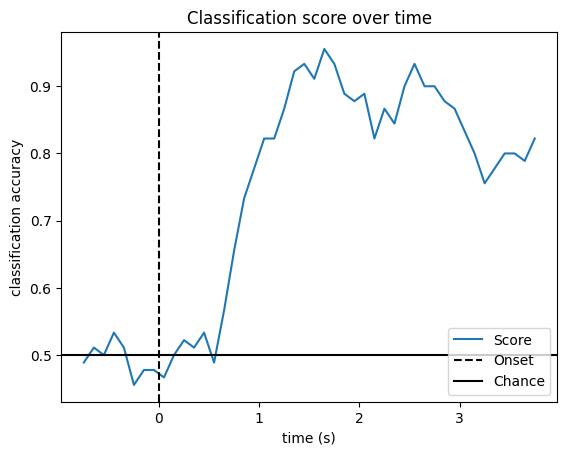

In [19]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

## Preprocessing

In [3]:
large_open_data = []
# This is a list of all the data for eyes opened
large_closed_data = []
# This is a list of all the data for eyes closed

for data in opened_files:
    large_open_data.append(mne.io.read_raw_edf(data, preload=True, verbose=False).get_data(verbose=False))

for data in closed_files:
    large_closed_data.append(mne.io.read_raw_edf(data, preload=True, verbose=False).get_data(verbose=False))

# This is the number of files for eyes opened
print(large_open_data.__len__())
# This is the number of files for eyes closed
print(large_closed_data.__len__())

19
19


1. Epochs
2. Type of Loss functions (rmsprop, adam, WGAN, min-max loss, adagrad)
3. Add seeds and tracking of seeds
4. Experiment with depth of GANS (complexity of the model)
5. Different values of lambda (gradient penalty value)
6. Weight initialization (rn using Standard normal, xavier)
7. Learning rate

In [6]:
NUM_EPOCHS = 20
PRINT_INTERVAL = 2 # every PRINT_INTERVAL epoch, print status
BATCH_SIZE = 13
NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 10
LATENT_SIZE = 100

MEAN = 0
STANDARD_DEVIATION = 0.02

training_data = np.array(large_open_data[0:BATCH_SIZE])
training_data = torch.tensor(training_data)

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, MEAN, STANDARD_DEVIATION)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = MEAN 
    sigma = STANDARD_DEVIATION
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.start = nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4)
        self.end = nn.Linear(10240, 9760)
        self.relu = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.block = nn.Sequential(
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(LATENT_SIZE, NUM_CHANNELS, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        x = self.start(x)
        x = self.relu(x)
        x = self.block(x) # upsample from 305 to 9760
        return self.end(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.start = nn.Conv1d(NUM_CHANNELS, LATENT_SIZE, kernel_size=9, stride=1, padding=4)
        self.end = nn.Linear(LATENT_SIZE * 9, 1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.block = nn.Sequential(
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(LATENT_SIZE, LATENT_SIZE, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(LATENT_SIZE, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = x.float()
        x = self.start(x)
        x = self.lrelu(x)
        x = self.block(x) # downsample from 9760 to 1
        x = x.view(BATCH_SIZE, -1)
        return self.end(x)

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for d_index in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, LATENT_SIZE, 10)
            fake = G(noise)
            critic_real = D(real).reshape(-1) # flatten
            critic_fake = D(fake).reshape(-1) # flatten
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data, disc, gen = train()

# save your models
torch.save(gen, 'gen.pt')
torch.save(disc, 'disc.pt')


Epoch 0: Critic error ([36528.750628348214]) Generator err ([-0.26427724957466125])
Epoch 2: Critic error ([36528.750628348214, 7.62978960715155, 8.280869196534004]) Generator err ([-0.26427724957466125, 0.4534228444099426, 0.007426450029015541])
Epoch 4: Critic error ([36528.750628348214, 7.62978960715155, 8.280869196534004, 9.466921581319726, 10.710384057495165]) Generator err ([-0.26427724957466125, 0.4534228444099426, 0.007426450029015541, -0.4532325863838196, -1.0192221403121948])
Epoch 6: Critic error ([36528.750628348214, 7.62978960715155, 8.280869196534004, 9.466921581319726, 10.710384057495165, 10.28597615150735, 10.198605764120053]) Generator err ([-0.26427724957466125, 0.4534228444099426, 0.007426450029015541, -0.4532325863838196, -1.0192221403121948, -1.0742181539535522, -0.5204664468765259])
Epoch 8: Critic error ([36528.750628348214, 7.62978960715155, 8.280869196534004, 9.466921581319726, 10.710384057495165, 10.28597615150735, 10.198605764120053, 10.876236732386669, 11.08

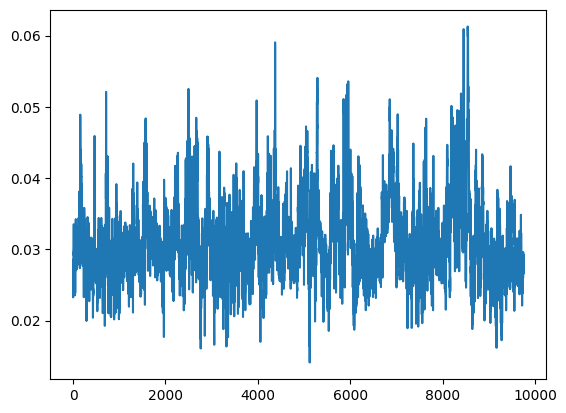

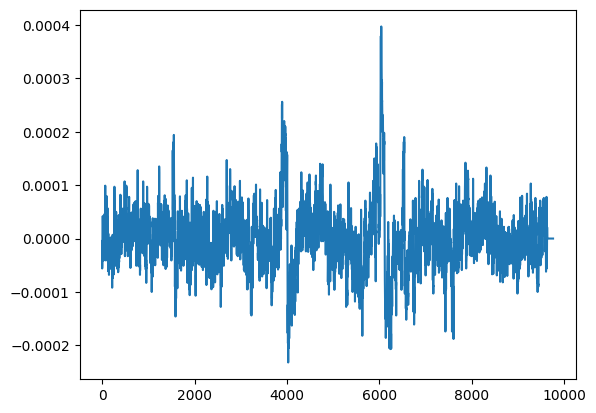

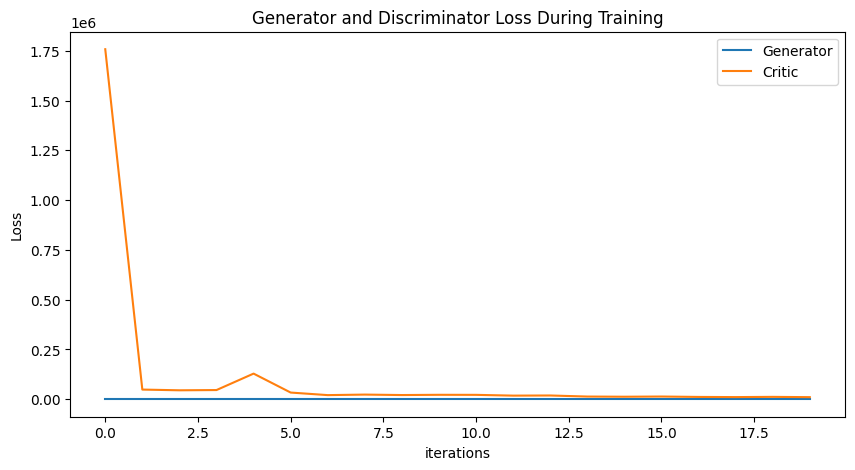

In [5]:
# generated data
values = generated_data[0, 0, :]
plt.plot(values.tolist())
plt.show()

plt.plot(training_data[0, 0, :])
plt.show()

# plotting G vs D losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_err,label="Generator")
plt.plot(critic_err,label="Critic")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [94]:
num_rows = 10
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    y = generated_data[i, 0, :]
    ax.plot(y.tolist())
plt.tight_layout()
plt.show()

IndexError: index 12 is out of bounds for dimension 0 with size 12

In [ ]:
# # With preprocessing:
# for data in opened_files:
#     data1 = mne.io.read_raw_edf(data, preload=True, verbose=False)
#     data1.filter(1.0, 30.0, fir_design="firwin", skip_by_annotation="edge", verbose=False)
#     ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800, verbose=False)
#     ica.fit(data1, verbose=False)
#     ica.exclude = [1, 2]
#     data1 = ica.apply(data1, verbose=False)

#     good_channels1 = data1.info['ch_names']

#     eeg_data1 = data1.get_data(picks=good_channels1)

#     large_open_data.append(eeg_data1)

### Averaging the Data

In [ ]:
# Currently there are issues with index 13

for i in range(len(large_open_data)):
    if large_open_data[i].shape != (64, 9760):
        print(i)
        print(large_open_data[i].shape)

large_open_data.pop(13)
large_closed_data.pop(13)



In [ ]:
# Convert the list of arrays into a NumPy array
main_array = np.array([large_closed_data]).squeeze()

# Calculate the average along the first axis (axis 0)
averaged_array_cl = np.mean(main_array, axis=0)


# Convert the list of arrays into a NumPy array
main_array = np.array([large_open_data]).squeeze()

# Calculate the average along the first axis (axis 0)
averaged_array_op = np.mean(main_array, axis=0)

In [ ]:
eeg_data = averaged_array_op
time = range(9760)

# Plot EEG data for all channels using Matplotlib
plt.figure(figsize=(10, 6))
for ch_idx in range(64):
    plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.ylim(-0.00005, 0.00005)
plt.show()

In [ ]:
eeg_data = averaged_array_cl
time = range(9760)

# Plot EEG data for all channels using Matplotlib
plt.figure(figsize=(10, 6))
for ch_idx in range(64):
    plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.ylim(-0.00005, 0.00005)

plt.show()

Here is some unaveraged data:

In [ ]:
eeg_data = raw_list[0].get_data()
time = raw_list[0].times

# Plot EEG data for all channels using Matplotlib
plt.figure(figsize=(10, 6))
for ch_idx in range(eeg_data.shape[0]):
    plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.show()

In [ ]:
eeg_data = raw_list[1].get_data()
time = raw_list[0].times

# Plot EEG data for all channels using Matplotlib
plt.figure(figsize=(10, 6))
for ch_idx in range(eeg_data.shape[0]):
    plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for ch_idx in range(eeg_data.shape[0]):
    if ch_idx == 1:
        plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}', alpha=1, color= 'green', zorder=25)
    else:
        plt.plot(time, eeg_data[ch_idx], label=f'Channel {ch_idx + 1}', alpha=0.1, color='grey')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data for All Channels')
plt.show()

## Machine Learning

We need to start off by loading in the datasets we'll be using. For now, we'll be using the motor imagery dataset. We've already called it into this file with `large_closed_data` and `large_open_data`.

In [ ]:
large_closed_data.__len__(), large_open_data.__len__()

Let's take a look at an individual sample first and try to figure out what we're looking at.

In [ ]:
large_closed_data[0].shape

From this we can see than an individual sample contains 64 channels and 9760 time points per sample. We'll see that this will stay the same for all of the EEG BCI dataset.

In [ ]:
large_closed_data[0][0].__len__()

In [ ]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.label = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = self.label
        return self.data[index], label 

In [ ]:
dataset = EEGDataset(large_closed_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
dataset.__getitem__(0)

In [ ]:
type(large_closed_data), type(large_closed_data[0])

In [ ]:
tensor_list = [torch.tensor(arr) for arr in large_closed_data]

# Convert the list of PyTorch tensors to a single PyTorch tensor
closed = torch.stack(tensor_list) * 100000


tensor_list = [torch.tensor(arr) for arr in large_open_data]

# Convert the list of PyTorch tensors to a single PyTorch tensor
opened = torch.stack(tensor_list) * 100000

In [ ]:
type(closed)

In [ ]:
# Assign labels
eyes_closed_labels = [0] * len(closed)
eyes_open_labels = [1] * len(opened)

# Combine datasets and labels
combined_data = torch.cat((closed, opened), dim=0)
combined_labels = eyes_closed_labels + eyes_open_labels

In [ ]:
combined_data.__len__(), combined_labels.__len__()

In [ ]:
# Split the combined data
train_data, test_data, train_labels, test_labels = train_test_split(
    combined_data, combined_labels, test_size=0.2, random_state=42)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dataset = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            dataset = self.transform(dataset)

        return dataset, label

# Define transformations (resize, normalize, augment, etc.) if needed
transform = transforms.Compose([
])

# Create data loaders
batch_size = 32

train_dataset = CustomDataset(train_data, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_data, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = CustomDataset(test_data, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class EEGClassificationModel(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(EEGClassificationModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 4879, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.float()  # Convert input to float data type
        x = torch.relu(self.conv1d(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 4879)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_channels = 64
num_classes = 2  # Change this based on your classification task

losses = []

# Create an instance of the model
model = EEGClassificationModel(num_channels, num_classes)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Validation loop (optional)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total}%")

# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

In [ ]:
# Plot losses
plt.plot(losses)
plt.title("Losses")
plt.show()